# SgrA* Comparison
---
This notebook compares Noisy [1,2] generated movies to the SgrA* data. 

**Note the 'dev' branch of ehtim is needed.**


[1] https://github.com/AFD-Illinois/noisy

[2] https://github.com/aviadlevis/pynoisy

In [359]:
import pynoisy
import ehtim as eh
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from tqdm.notebook import tqdm
import time as ttime
from ehtim.imaging import starwarps as sw
import ehtim.scattering as so
import ehtim.imaging.dynamical_imaging as di
import sys 
from scipy.ndimage import median_filter
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [287]:
"""
Function definitions
"""
def load_sgra_obs(ehtim_home, uvfits_path):
    """Load SgrA observations.
    
    Args:
        eht_home (str):  Directory where eht-imaging library is located.
        uvfits_path (str): Relative path from the eht_home directory to the observation file.
        
    Returns:
        obs_sgra (Obsdata): observation object 
    """
    obsfilename = os.path.join(ehtim_home, uvfits_path)
    obs_sgra = eh.obsdata.load_uvfits(obsfilename, remove_nan=True)
    
    # Load telescope site locations and SEFDs (how noisy they are)
    eht = eh.array.load_txt(os.path.join(ehtim_home, 'arrays/EHT2017_m87.txt'))

    # Copy the correct mount types
    t_obs = list(obs_sgra.tarr['site'])
    t_eht = list(eht.tarr['site'])
    t_conv = {'AA':'ALMA','AP':'APEX','SM':'SMA','JC':'JCMT','AZ':'SMT','LM':'LMT','PV':'PV','SP':'SPT'}
    for t in t_conv.keys():
        if t in obs_sgra.tarr['site']:
            for key in ['fr_par','fr_elev','fr_off']:
                obs_sgra.tarr[key][t_obs.index(t)] = eht.tarr[key][t_eht.index(t_conv[t])]
                
    return obs_sgra

def ehtim_movie(frames, obs_sgra, total_flux=2.23, fov=95, start_time=None, end_time=None):
    """Generate ehtim Movie object.
    
    Args:
        frames (list): A list of movie frames.
        obs_sgra (Obsdata): observation object.
        start_time (float): Start time of the movie. If None use SgrA observation start time.
        end_time (float): End time of the movie. If None use SgrA observation end time.
        total_flux (float): normalizing constant for the images.
        fov (float): field of view of the image in micro arcseconds.
        
    Returns:
        movie (Movie): An ehtim.Movie object containing normalized frames.
        obs (Obsdata): observation object. 
    """
    mjd = obs_sgra.mjd    # modified julian date of observation
    ra = obs_sgra.ra      # ra of the source - sgra a*
    dec = obs_sgra.dec    # dec of the source - sgr a*
    rf = obs_sgra.rf      # reference frequency observing at corresponding to 1.3 mm wavelength
    fov *= eh.RADPERUAS
    
    start_time = obs_sgra.tstart if start_time is None else start_time
    end_time = obs_sgra.tstop if end_time is None else end_time
    times = np.linspace(start_time, end_time, len(frames))
    
    movie_frames = []
    for frame, time in zip(frames, times):
        im = eh.image.make_empty(frame.shape[0], fov, ra, dec, rf, source='SgrA')
        im.mjd = mjd
        im.time = time
        im.imvec = total_flux * frame.reshape(-1) / frame.sum()
        movie_frames.append(im)
        
    movie = eh.movie.merge_im_list(movie_frames)
    
    # change the synthetic image coordinates to align with the obs
    movie.ra = obs_sgra.ra
    movie.dec = obs_sgra.dec
    movie.rf = obs_sgra.rf
    
    return movie

def plot_amplitudes(obs_sgra, obs_sgr_avg, obs_noisy, obs_noisy_avg, inttime=300):
    fig, ax = plt.subplots(1,2, figsize=(9,4))
    obs_sgra.plotall('uvdist','amp', axis=ax[0], label='SgrA', legend=True, ebar=False);
    obs_noisy.plotall('uvdist','amp', axis=ax[0], label='Noisy', legend=True, marker='^', color='r', ebar=False);
    ax[0].set_title('No average', fontsize=12);
    ax[0].legend()
    obs_sgr_avg.plotall('uvdist','amp', axis=ax[1], label='SgrA', legend=True, ebar=False);
    obs_noisy_avg.plotall('uvdist','amp', axis=ax[1], label='Noisy', legend=True, marker='^', color='r', ebar=False);
    ax[1].set_title('{}s Average'.format(inttime), fontsize=12);
    ax[1].legend()
    
def plot_closure_phases(obs_sgra, obs_noisy, triangles=[['AZ', 'SM', 'SP'],['AA', 'SM', 'LM']]):
    fig, axes = plt.subplots(2, len(triangles), figsize=(8,8))
    all_sites = ['AA','AP','AZ','LM','PV','SM','JC','SP','SR']
    for i, triangle in enumerate(triangles):
        eh.plot_cphase_obs_compare([obs_sgra, obs_noisy], *triangle, axis=axes[0,i], 
                                   ebar=False, legendlabels=['SgrA', 'Noisy'])
        axes[0,i].legend()
        
        triangle_obs = all_sites.copy()
        for site in triangle:
            triangle_obs.remove(site)
        obs = obs_sgra.flag_sites(triangle_obs)
        obs.plotall('u','v', axis=axes[1,i], conj=True, rangey=[-1e10, 1e10], rangex=[-1e10, 1e10])
    fig.tight_layout()

def plot_envelope(envelope):
    fig, ax = plt.subplots(1, 2, figsize=(6,3))
    plt.sca(ax[0])
    envelope.imshow()
    plt.sca(ax[1])
    plt.plot(envelope.data[128,:])
    ax[1].set_title('Center slice', fontsize=18)
    plt.tight_layout()
    
def add_pol_movie(movie, npixels=50, powerDropoff=2.0, covfrac=0.4, min_dolp=0.0, 
                  max_dolp=0.75, circpolfrac=0.01, seed=1):
    
    empty = eh.image.make_empty(npixels, movie.fovx(), movie.ra, movie.dec, rf=movie.rf, source=movie.source)
    
    pol_movie = movie.copy()
        
    np.random.seed(seed)
    flat = empty.copy()
    flat.imvec = np.ones(flat.imvec.shape)
    imCov =  sw.gaussImgCovariance_2(flat, powerDropoff=powerDropoff, frac=covfrac)

    zeros = np.zeros(flat.imvec.shape)
    dolp = np.abs(np.random.multivariate_normal(zeros, imCov))
    dolp = (max_dolp - min_dolp) * (dolp - dolp.min()) / (dolp.max() - dolp.min()) + min_dolp
    
    aolp = np.random.multivariate_normal(zeros, imCov)
    aolp = 2 * np.pi * (aolp - aolp.min())/(aolp.max() - aolp.min()) - np.pi 
    
    circpol = np.random.multivariate_normal(zeros, imCov)
    circpol = 2 * circpolfrac * (circpol - circpol.min())/(circpol.max() - circpol.min()) - circpolfrac 
    
    stokes_q_frames = []
    stokes_u_frames = []
    stokes_v_frames = []
    for frame in pol_movie.im_list():
        i_frame = frame.regrid_image(targetfov=frame.fovx(), npix=npixels).ivec
        q_frame = i_frame * dolp * np.cos(aolp) * np.cos(circpol)
        u_frame = i_frame * dolp * np.sin(aolp) * np.cos(circpol) 
        v_frame = i_frame * dolp * np.sin(circpol)
        image = empty.copy()
        image.qvec = q_frame
        image.uvec = u_frame
        image.vvec = v_frame
        image = image.regrid_image(targetfov=image.fovx(), npix=movie.xdim)
        stokes_q_frames.append(image.imarr(pol='Q'))
        stokes_u_frames.append(image.imarr(pol='U'))
        stokes_v_frames.append(image.imarr(pol='V'))

    pol_movie.add_pol_movie(stokes_q_frames, pol='Q')
    pol_movie.add_pol_movie(stokes_u_frames, pol='U')
    pol_movie.add_pol_movie(stokes_v_frames, pol='V')
    
    return pol_movie  

def load_all_movies(directory):
    file_paths = glob.glob(directory + '/*.hdf5')
    movies = [eh.movie.load_hdf5(path) for path in file_paths]
    return movies

## Load SgrA* observations 

In [288]:
ehtim_home = '/home/aviad/Code/eht-imaging/'
uvfits_path = 'SgrA/data/calibrated_data_oct2019/frankenstein_3599_lo_SGRA_polcal_netcal_LMTcal_10s.uvfits'
obs_sgra = load_sgra_obs(ehtim_home, uvfits_path)

Loading uvfits:  /home/aviad/Code/eht-imaging/SgrA/data/calibrated_data_oct2019/frankenstein_3599_lo_SGRA_polcal_netcal_LMTcal_10s.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!


In [294]:
import glob

fits_paths = glob.glob(os.path.join(ehtim_home, 'SgrA/synthetic_data_SGRA_3599_lo/representative_models/*.fits'))
envelope = eh.image.load_fits(fits_paths[0])



Loading fits image:  /home/aviad/Code/eht-imaging/SgrA/synthetic_data_SGRA_3599_lo/representative_models/ring_model_fiducial2.fits
reading stokes images from top HDU -- assuming IQUV


## Static Ring

<IPython.core.display.Javascript object>


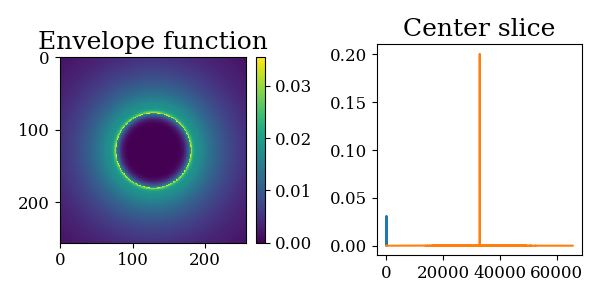

In [38]:
envelope = pynoisy.RingEnvelope(inner_decay=5)
noisy_movie = pynoisy.Movie()
noisy_movie.duplicate_single_frame(envelope.data, num_frames=100)

%matplotlib notebook
plot_envelope(envelope)

<IPython.core.display.Javascript object>


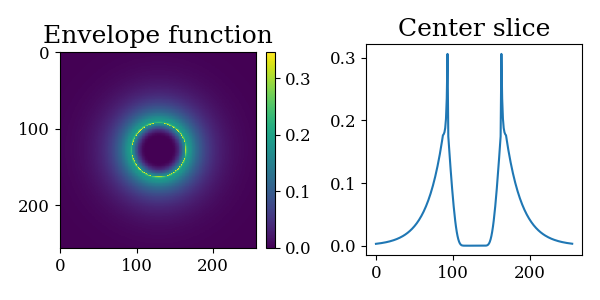

In [304]:
"""
Define a static ring envelope and duplicate it to generate a static movie
"""
envelope = pynoisy.RingEnvelope(inner_radius=0.135, photon_ring_thickness=0.025,
                                photon_ring_decay=200, inner_decay=12, ascent=.65)
noisy_movie = pynoisy.Movie()
noisy_movie.duplicate_single_frame(envelope.data, num_frames=100)

%matplotlib notebook
plot_envelope(envelope)

<IPython.core.display.Javascript object>


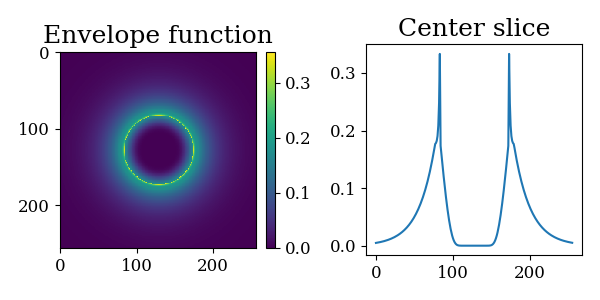

In [27]:
"""
Define a static ring envelope and duplicate it to generate a static movie
"""
envelope = pynoisy.RingEnvelope(inner_radius=0.175, photon_ring_thickness=0.025,
                                photon_ring_decay=200, inner_decay=12, ascent=.65)
noisy_movie = pynoisy.Movie()
noisy_movie.duplicate_single_frame(envelope.data, num_frames=100)

%matplotlib notebook
plot_envelope(envelope)

In [398]:
path = '/home/aviad/Code/eht-imaging/SgrA/synthetic_rings_asymetric/09-Mar-2020-19:08:47/envelope_flux2.23_fov125.0_bright_spot_angle0.0_compact_zbl0.8_compact_zbl_frac0.5_brightness_contrast0.5_radius29.5_width20.5_evolution_angle60.0_rotationccw_eps0.1_dur0.1_amp0.4.pkl'
#path = '/home/aviad/Code/eht-imaging/SgrA/synthetic_rings_asc1.0_innerdec5.0/angle0.8_counter_clockwise_eps0.10_len0.1_amp0.50.pkl'

movie = pynoisy.Movie()
movie.load(path)

In [403]:
for frame in frames:
    median = median_filter(frame, size=5)
    mean = frame.mean() + 1e-10
    pixel_std = frame / mean
    frame[pixel_std > 10] = median[pixel_std > 10]

In [405]:
path = '/home/aviad/Code/eht-imaging/SgrA/synthetic_rings_asymetric/09-Mar-2020-19:08:47/envelope_flux2.23_fov125.0_bright_spot_angle0.0_compact_zbl0.8_compact_zbl_frac0.5_brightness_contrast0.5_radius29.5_width20.5_evolution_angle60.0_rotationccw_eps0.1_dur0.1_amp0.4.hdf5'
path = '/home/aviad/Code/eht-imaging/SgrA/synthetic_data_SGRA_3599_lo/representative_models/12-Mar-2020-12:37:33/dbsrc_model_fiducial_angle60.0_radius0.2_rotationcw_eps0.1_dur0.1_amp0.3_tau1.0_lam1.5_tensor_ratio0.1.hdf5'
movie = eh.movie.load_hdf5(path)


In [76]:
frames = movie.frames
mjd = obs_sgra.mjd  # modified julian date of observation
ra = obs_sgra.ra  # ra of the source - sgra a*
dec = obs_sgra.dec  # dec of the source - sgr a*
rf = obs_sgra.rf  # reference frequency observing at corresponding to 1.3 mm wavelength
fov *= eh.RADPERUAS

start_time = obs_sgra.tstart if start_time is None else start_time
end_time = obs_sgra.tstop if end_time is None else end_time
times = np.linspace(start_time, end_time, len(frames))

std_clip
movie_frames = []
flux_normalization = total_flux / frames.mean(axis=0).sum()

for frame, time in zip(frames, times):
    im = eh.image.make_empty(frame.shape[0], fov, ra, dec, rf, source='SgrA')
    im.mjd = mjd
    im.time = time
    imvec = flux_normalization * frame.reshape(-1)
    std = imvec.std()/(imvec.sum() + 1e-10)
    movie_frames.append(im)

movie_eht = eh.movie.merge_im_list(movie_frames)

(100, 256, 256)

In [349]:
path = '/home/aviad/Code/eht-imaging/SgrA/synthetic_rings_asymetric/09-Mar-2020-19:08:47/envelope_flux2.23_fov125.0_bright_spot_angle0.0_compact_zbl0.8_compact_zbl_frac0.5_brightness_contrast0.5_radius29.5_width20.5_evolution_angle60.0_rotationccw_eps0.1_dur0.1_amp0.4.pkl'
#path = '/home/aviad/Code/eht-imaging/SgrA/synthetic_rings_asc1.0_innerdec5.0/angle0.8_counter_clockwise_eps0.10_len0.1_amp0.50.pkl'
#path = '/home/aviad/Code/eht-imaging/SgrA/synthetic_disks/angle1.0_counter_clockwise_eps0.05_len0.5_amp0.15_rat0.1_dec15.pkl'
fov = 125.0
start_time=None
end_time=None
movie = pynoisy.Movie()
movie.load(path)
frames = movie.frames
mjd = obs_sgra.mjd  # modified julian date of observation
ra = obs_sgra.ra  # ra of the source - sgra a*
dec = obs_sgra.dec  # dec of the source - sgr a*
rf = obs_sgra.rf  # reference frequency observing at corresponding to 1.3 mm wavelength
fov *= eh.RADPERUAS

start_time = obs_sgra.tstart if start_time is None else start_time
end_time = obs_sgra.tstop if end_time is None else end_time
times = np.linspace(start_time, end_time, len(frames))

movie_frames = []
pixel_std = (frames.std(axis=0) / (frames.mean(axis=0) + 1e-10))
flux_normalization = total_flux / (frames.mean(axis=0)[pixel_std <= 1].sum() + 1e-10)
for frame, time in zip(frames, times):
    im = eh.image.make_empty(frame.shape[0], fov, ra, dec, rf, source='SgrA')
    im.mjd = mjd
    im.time = time
    imvec = flux_normalization * frame.reshape(-1)
    #imvec[pixel_std.reshape(-1) > 3] = 0
    im.imvec = imvec
    im = im.add_random_pol(mag=0.5, corr=0.1, cmag=0.01, ccorr=0.1, seed=1)
    movie_frames.append(im)
    
eht_movie = eh.movie.merge_im_list(movie_frames)
#di.export_movie(eht_movie.im_list(), fps=10, out='test1.mp4')


Merging 100 frames from MJD 57850 4.05 hr to MJD 57850 15.60 hr


<IPython.core.display.Javascript object>


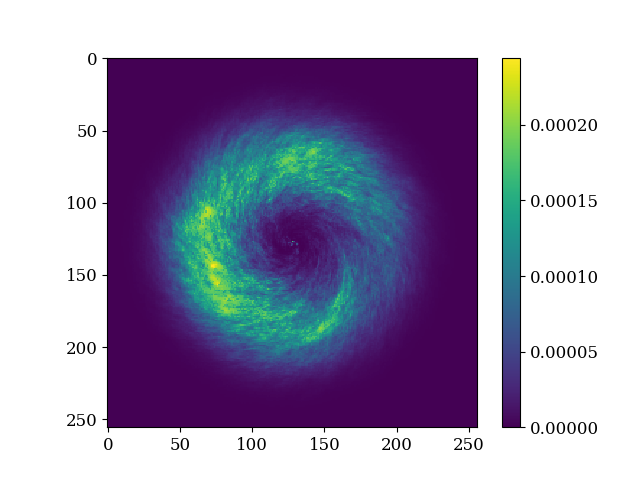

In [397]:
plt.figure()
frame = eht_movie.get_frame(55).imarr()
median = median_filter(frame, size=5)
frame[frame / frame.mean() > 10] = median[frame / frame.mean() > 10]
plt.imshow(frame)
plt.colorbar()


Merging 100 frames from MJD 57850 4.05 hr to MJD 57850 15.60 hr
Producing clean visibilities from movie with nfft FT . . . 
Scattering Visibilities with Sgr A* kernel!


<IPython.core.display.Javascript object>


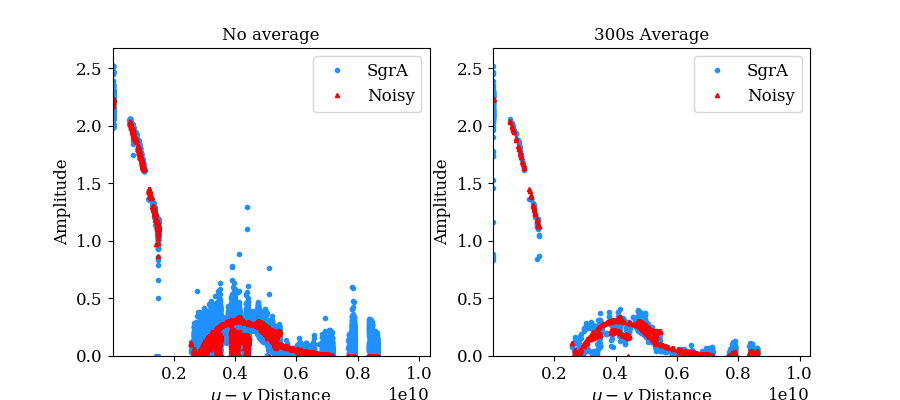

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


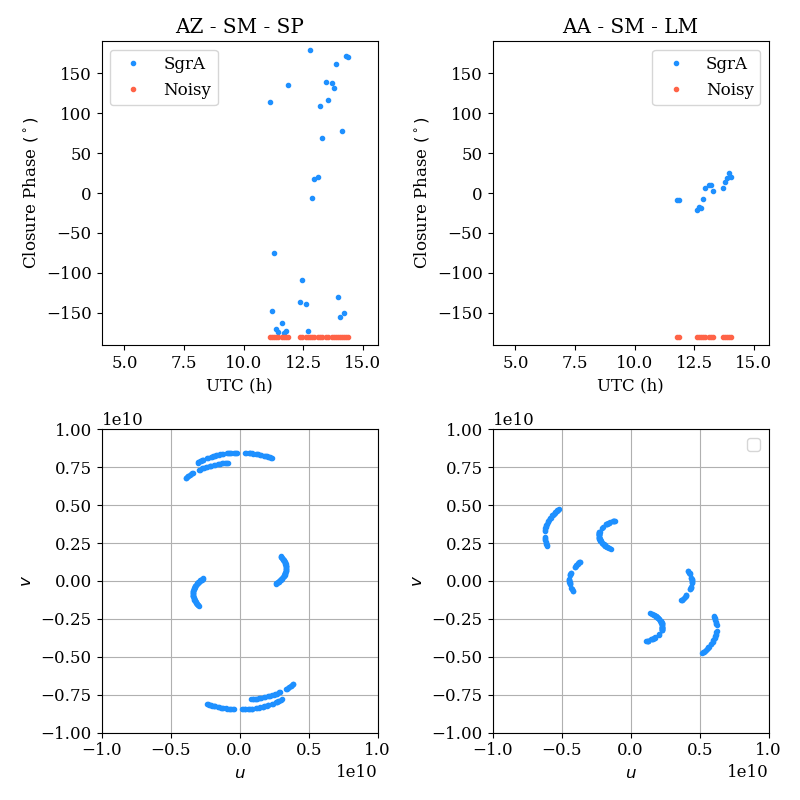

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Flagged 835/960 visibilities
Flagged 851/960 visibilities


In [28]:
"""
Generate a Movie object compare SgrA-like observations amplitudes
"""
movie = ehtim_movie(noisy_movie.frames, obs_sgra, total_flux=2.23, fov=125)
obs_noisy = movie.observe_same_nonoise(obs_sgra, sgrscat=True)

inttime = 300
obs_sgr_avg = obs_sgra.avg_coherent(inttime)
obs_noisy_avg = obs_noisy.avg_coherent(inttime)
    
%matplotlib notebook
plot_amplitudes(obs_sgra, obs_sgr_avg, obs_noisy, obs_noisy_avg, inttime)
plot_closure_phases(obs_sgr_avg, obs_noisy_avg)

## Static Asymetric Ring

<IPython.core.display.Javascript object>


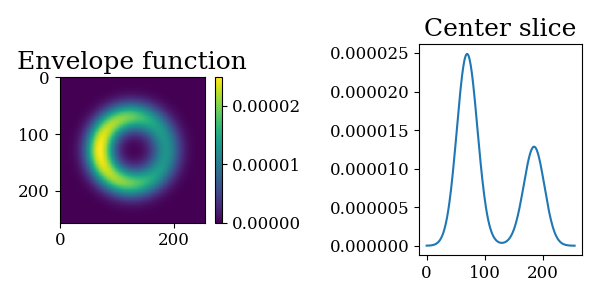

In [22]:
bright_spot_angle = np.deg2rad(0.0)
compact_zbl = 0.8
compact_zbl_frac=0.5
brightness_contrast = 0.5
radius = 29.5*eh.RADPERUAS
width = 20*eh.RADPERUAS
empty = eh.image.make_empty(npix=256, fov=125*eh.RADPERUAS, ra=12.51, dec=12.39, rf=230000000000.0, source='SgrA')
data = empty.add_ring_m1(compact_zbl_frac*compact_zbl, compact_zbl_frac*compact_zbl*brightness_contrast, radius, bright_spot_angle, width)
envelope = pynoisy.Envelope(data=data.imarr(), amplitude=0.01)

noisy_movie = pynoisy.Movie()
noisy_movie.duplicate_single_frame(envelope.data, num_frames=100)

%matplotlib notebook
plot_envelope(envelope)


Merging 100 frames from MJD 57850 4.05 hr to MJD 57850 15.60 hr
Producing clean visibilities from movie with nfft FT . . . 
Scattering Visibilities with Sgr A* kernel!


<IPython.core.display.Javascript object>


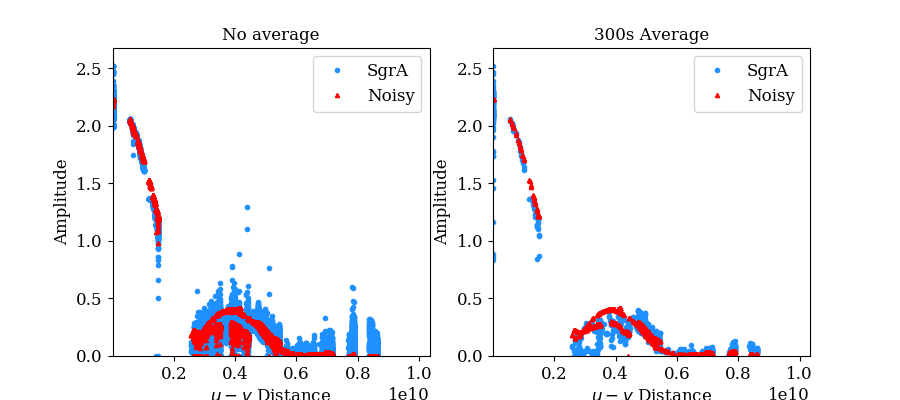

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


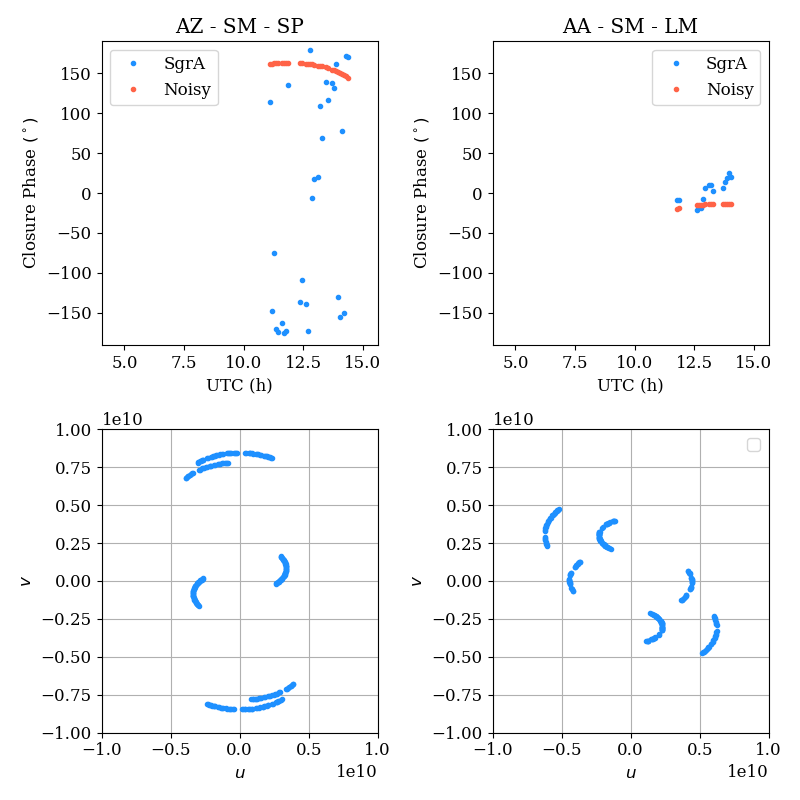

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Flagged 835/960 visibilities
Flagged 851/960 visibilities


In [23]:
movie = ehtim_movie(noisy_movie.frames, obs_sgra, total_flux=2.23, fov=125)
obs_noisy = movie.observe_same_nonoise(obs_sgra, sgrscat=True)

inttime = 300
obs_sgr_avg = obs_sgra.avg_coherent(inttime)
obs_noisy_avg = obs_noisy.avg_coherent(inttime)
    
%matplotlib notebook
plot_amplitudes(obs_sgra, obs_sgr_avg, obs_noisy, obs_noisy_avg, inttime)
plot_closure_phases(obs_sgr_avg, obs_noisy_avg)

## Static Disk

<IPython.core.display.Javascript object>


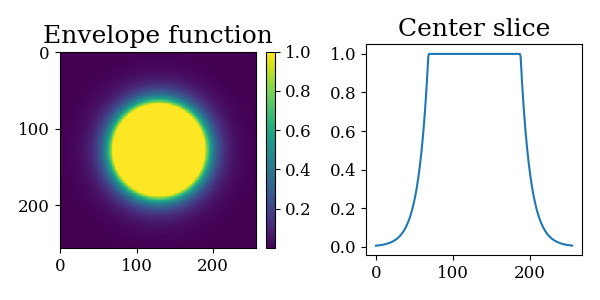

In [5]:
envelope = pynoisy.DiskEnvelope(radius=39.346734 / 160.0, decay=20)
noisy_movie = pynoisy.Movie()
noisy_movie.duplicate_single_frame(envelope.data, num_frames=100)
%matplotlib notebook
fig, ax = plt.subplots(1, 2, figsize=(6,3))
plt.sca(ax[0])
envelope.imshow()
plt.sca(ax[1])
plt.plot(envelope.data[128,:])
ax[1].set_title('Center slice', fontsize=18)
plt.tight_layout()


Merging 100 frames from MJD 57850 4.05 hr to MJD 57850 15.60 hr
Producing clean visibilities from movie with nfft FT . . . 
Scattering Visibilities with Sgr A* kernel!


<IPython.core.display.Javascript object>


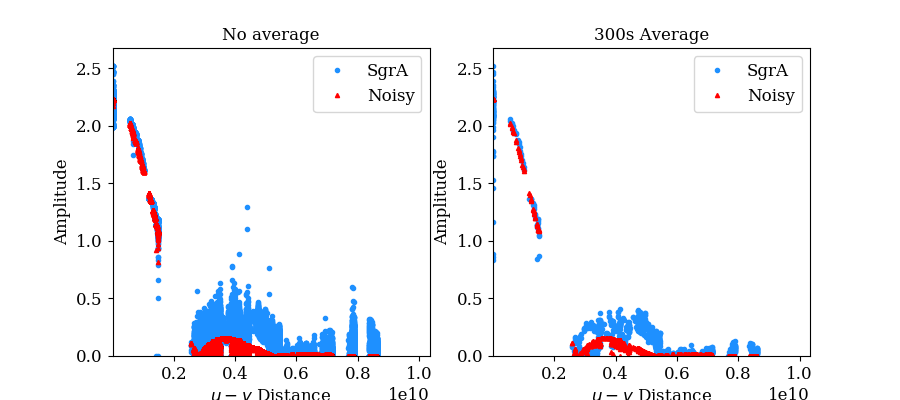

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


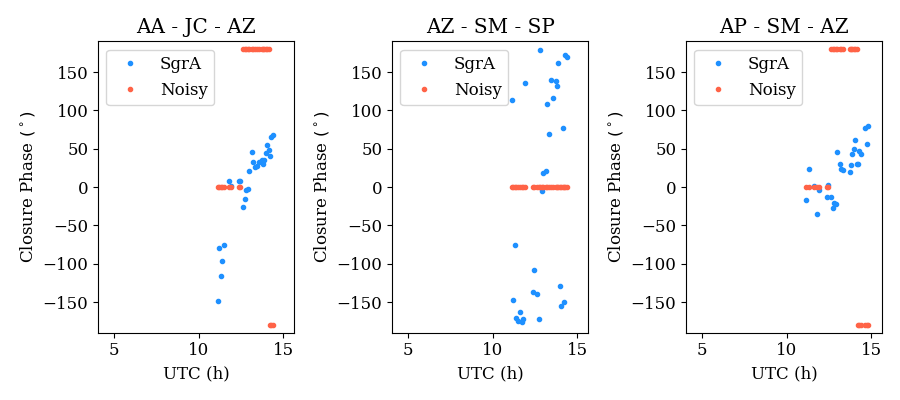

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


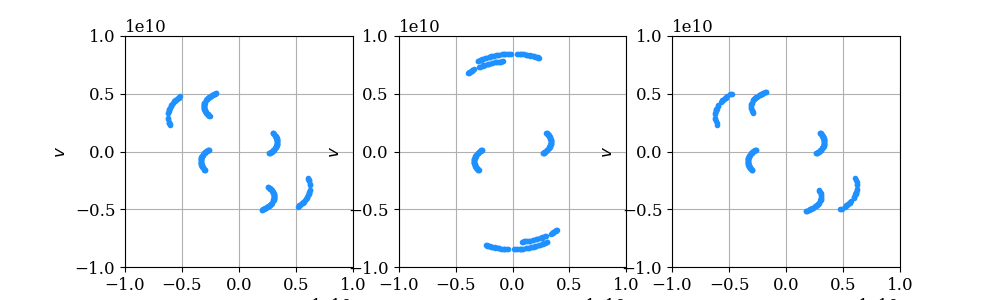

Flagged 839/960 visibilities
Flagged 835/960 visibilities
Flagged 855/960 visibilities


In [8]:
"""
Generate a Movie object compare SgrA-like observations amplitudes
"""
movie = ehtim_movie(noisy_movie.frames, obs_sgra, total_flux=2.23, fov=160)
obs_noisy = movie.observe_same_nonoise(obs_sgra, sgrscat=True)

inttime = 300
obs_sgr_avg = obs_sgra.avg_coherent(inttime)
obs_noisy_avg = obs_noisy.avg_coherent(inttime)
    
%matplotlib notebook
plot_amplitudes(obs_sgra, obs_sgr_avg, obs_noisy, obs_noisy_avg, inttime)
plot_closure_phases(obs_sgr_avg, obs_noisy_avg)

## Static Double Source

<IPython.core.display.Javascript object>


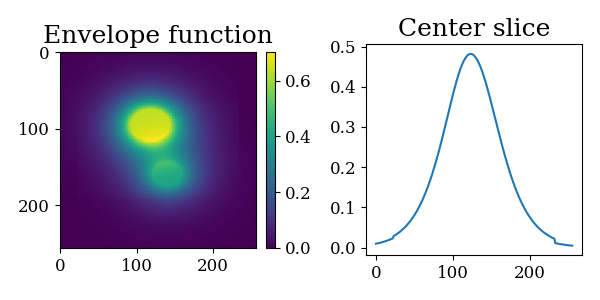


Merging 100 frames from MJD 57850 4.05 hr to MJD 57850 15.60 hr


In [55]:
angle = np.deg2rad(105.89)
distance = 55.56 / 160.0
radius1 = 36.67 / 320.0
radius2 = 27.78 / 320.0
rotation = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), -np.cos(angle)]]).T
opening_angle = np.pi/3.0
direction1 = pynoisy.RotationDirection.clockwise
direction2 = pynoisy.RotationDirection.counter_clockwise

# Define envelope
disk1 = pynoisy.DiskEnvelope(radius=radius1, decay=10)
disk1.shift(*np.dot(rotation, np.array([distance/2.0, 0.0])))
disk2 = pynoisy.DiskEnvelope(radius=radius2, decay=10)
disk2.shift(*np.dot(rotation,  np.array([-distance/2.0, 0.0])))
envelope = (disk1 + disk2 * 0.6) / 1.6
plot_envelope(envelope)

# Define advection
advection1 = pynoisy.DiskAdvection(scaling_radius=radius1, direction=direction1)
advection1.shift(*np.dot(rotation, np.array([distance / 2.0, 0.0])))
advection2 = pynoisy.DiskAdvection(scaling_radius=radius2, direction=direction2)
advection2.shift(*np.dot(rotation, np.array([-distance / 2.0, 0.0])))
advection = advection1 + advection2
advection.plot_velocity()

# Define diffusion
diffusion1 = pynoisy.DiskDiffusion(scaling_radius=radius1)
diffusion2 = pynoisy.DiskDiffusion(scaling_radius=radius2)
indices = np.bitwise_and(diffusion1.r >= radius1*0.8, diffusion1.r <= radius1 * 1.2)
diffusion1[indices] = pynoisy.RingDiffusion(opening_angle=-opening_angle * direction1.value)
indices = np.bitwise_and(diffusion2.r >= radius2 * 0.8, diffusion2.r <= radius2 * 1.2)
diffusion2[indices] = pynoisy.RingDiffusion(opening_angle=-opening_angle * direction2.value)
diffusion1.shift(*np.dot(rotation, np.array([distance / 2.0, 0.0])))
diffusion2.shift(*np.dot(rotation, np.array([-distance / 2.0, 0.0])))
diffusion = diffusion1 + diffusion2

# Generate static movie from envelope
noisy_movie = pynoisy.Movie()
noisy_movie.duplicate_single_frame(envelope.data, num_frames=100)
movie = ehtim_movie(noisy_movie.frames, obs_sgra, total_flux=2.23, fov=160)

In [ ]:
"""
Generate a Movie object compare SgrA-like observations amplitudes
"""
movie = ehtim_movie(noisy_movie.frames, obs_sgra, total_flux=2.23, fov=160)
obs_noisy = movie.observe_same_nonoise(obs_sgra, sgrscat=True)

inttime = 300
obs_sgr_avg = obs_sgra.avg_coherent(inttime)
obs_noisy_avg = obs_noisy.avg_coherent(inttime)
    
%matplotlib notebook / 320
plot_amplitudes(obs_sgra, obs_sgr_avg, obs_noisy, obs_noisy_avg, inttime)
plot_closure_phases(obs_sgr_avg, obs_noisy_avg)

## Dynamic Ring

In [277]:
"""
Loading all movies takes ~2:40 minutes for 132 movies
"""
directory = os.path.join(
    ehtim_home, 'SgrA/synthetic_rings_total_flux2.23_fov95_inner_radius0.2_inner_decay5.0_ascent1.0'
)
file_paths = glob.glob(directory + '/*.hdf5')


<IPython.core.display.Javascript object>


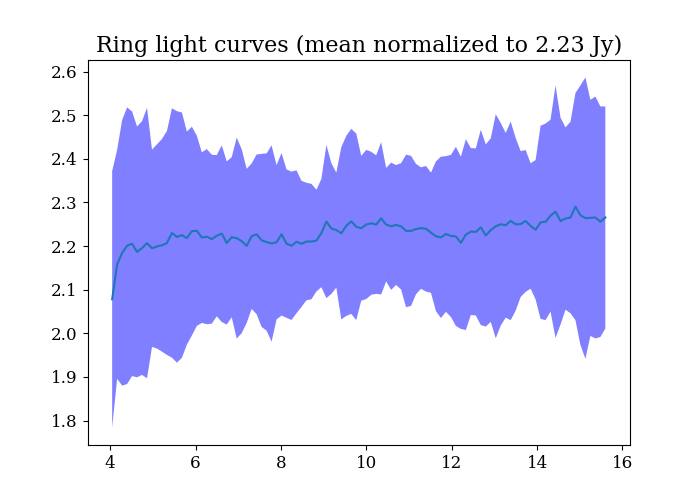

In [46]:
%matplotlib notebook
fig, ax = plt.subplots(1, figsize=(7,5))
mean = light_curves.mean(axis=0)
std = light_curves.std(axis=0)
ax.set_title('Ring light curves (mean normalized to 2.23 Jy)', fontsize=16)
ax.plot(times, mean)
ax.fill_between(times, mean + std, mean - std, facecolor='blue', alpha=0.5)


In [35]:
mov = eh.movie.load_hdf5('/home/aviad/Code/eht-imaging/SgrA/synthetic_rings_total_flux2.23_fov95_inner_radius0.2_inner_decay5.0_ascent1.0/angle1.3_clockwise_eps0.10_len0.5_amp0.15.hdf5')

In [36]:
lc = mov.lightcurve

In [45]:
file_paths[20], file_paths[5], file_paths[97]

('/home/aviad/Code/eht-imaging/SgrA/synthetic_rings_total_flux2.23_fov95_inner_radius0.2_inner_decay5.0_ascent1.0/angle0.8_clockwise_eps0.30_len0.5_amp0.30.hdf5',
 '/home/aviad/Code/eht-imaging/SgrA/synthetic_rings_total_flux2.23_fov95_inner_radius0.2_inner_decay5.0_ascent1.0/angle0.8_clockwise_eps0.10_len0.5_amp0.30.hdf5',
 '/home/aviad/Code/eht-imaging/SgrA/synthetic_rings_total_flux2.23_fov95_inner_radius0.2_inner_decay5.0_ascent1.0/angle1.3_clockwise_eps0.10_len0.5_amp0.15.hdf5')

In [10]:
mjd = obs_sgra.mjd  # modified julian date of observation
ra = obs_sgra.ra  # ra of the source - sgra a*
dec = obs_sgra.dec  # dec of the source - sgr a*
rf = obs_sgra.rf  # reference frequency observing at corresponding to 1.3 mm wavelength
fov = 95 * eh.RADPERUAS
total_flux = 2.23

start_time = obs_sgra.tstart
end_time = obs_sgra.tstop 
times = np.linspace(start_time, end_time, 100)

folder_path = os.path.join(ehtim_home, 'SgrA/synthetic_rings_asc1.0_innerdec5.0')
files_paths = glob.glob(folder_path + '/*.pkl')

noisy_movie = pynoisy.Movie()
movies = []
light_curves = []
for path in tqdm(files_paths, desc='files'):
    noisy_movie.load(path)
    flux_normalization = total_flux / noisy_movie.frames.mean(axis=0).sum()
    movie_frames = []
    for frame, time in zip(noisy_movie.frames, times):
        im = eh.image.make_empty(frame.shape[0], fov, ra, dec, rf, source='SgrA')
        im.mjd = mjd
        im.time = time
        im.imvec = flux_normalization *  frame.reshape(-1)
        movie_frames.append(im)
        
    movie = eh.movie.merge_im_list(movie_frames)
    sys.stdout.write("\033[F")
    sys.stdout.flush()
    
    # change the synthetic image coordinates to align with the obs
    movie.ra = obs_sgra.ra
    movie.dec = obs_sgra.dec
    movie.rf = obs_sgra.rf
    movie.reset_interp(interp='linear', bounds_error=False)
    
    movies.append(movie)
    light_curves.append(movie.lightcurve)


Merging 100 frames from MJD 57850 4.05 hr to MJD 57850 15.60 hr

Merging 100 frames from MJD 57850 4.05 hr to MJD 57850 15.60 hr



<IPython.core.display.Javascript object>


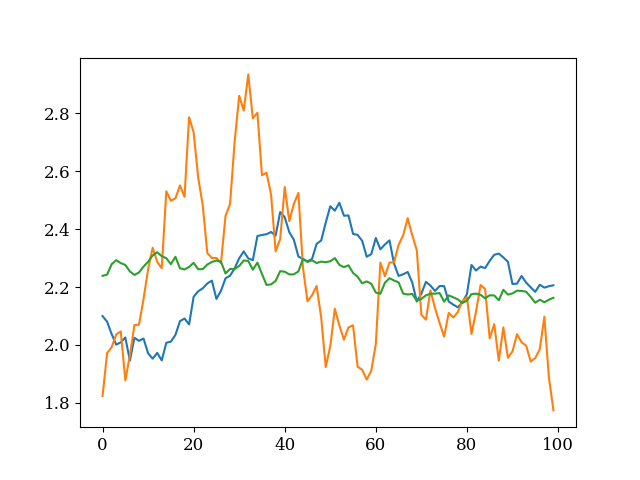

In [44]:
plt.figure()
plt.plot(light_curves[5])
plt.plot(light_curves[20])
plt.plot(light_curves[97])

In [56]:
hyperparams_sets = [{'total_flux': 2.23, 'fov': 95, 'inner_radius': 0.2, 'inner_decay': 5.0, 'ascent': 1.0},
                    {'total_flux': 2.23, 'fov': 150, 'inner_radius': 0.135, 'inner_decay': 15.0, 'ascent': 0.65}]
hyperparams = hyperparams_sets[0]
output_folder = os.path.join(
    ehtim_home,'SgrA/synthetic_rings' + ''.join(['_{}{}'.format(key, value) for key, value in hyperparams.items()])
)
import itertools
# Parameters for different ring evolutions
opening_angles = [np.pi/2.5, np.pi/4]
rotation_directions = [pynoisy.RotationDirection.clockwise, pynoisy.RotationDirection.counter_clockwise]
forcing_strengths = [0.05, 0.1]
evolution_lengths = [0.1, 0.5]
envelope_amplitudes = [0.1, 0.2, 0.3]

params = list(itertools.product(opening_angles, rotation_directions, forcing_strengths, evolution_lengths, envelope_amplitudes))[0]

In [57]:
output_path = os.path.join(
    output_folder, 'angle{:1.1f}_{}_eps{:1.2f}_len{:1.1f}_amp{:1.2f}'.format(params[0], params[1].name, params[2], params[3], params[4])
)

In [59]:
output_path

'/home/aviad/Code/eht-imaging/SgrA/synthetic_rings_total_flux2.23_fov95_inner_radius0.2_inner_decay5.0_ascent1.0/angle1.3_clockwise_eps0.05_len0.1_amp0.10'

In [11]:
import pynoisy.eht_functions as ehtf

output_folder = os.path.join(
    ehtim_home,'SgrA/synthetic_rings' + ''.join(['_{}{}'.format(key, value) for key, value in hyperparams.items()])
)
files_names = [file.rsplit('/')[-1] for file in files_paths]

for eht_movie, file_name in zip(movies, files_names):
    output_path = os.path.join(output_folder, file_name[:-3])
    eht_movie.save_hdf5(output_path + 'hdf5')
    di.export_movie(eht_movie.im_list(), fps=10, out=output_path + 'mp4')

<IPython.core.display.Javascript object>


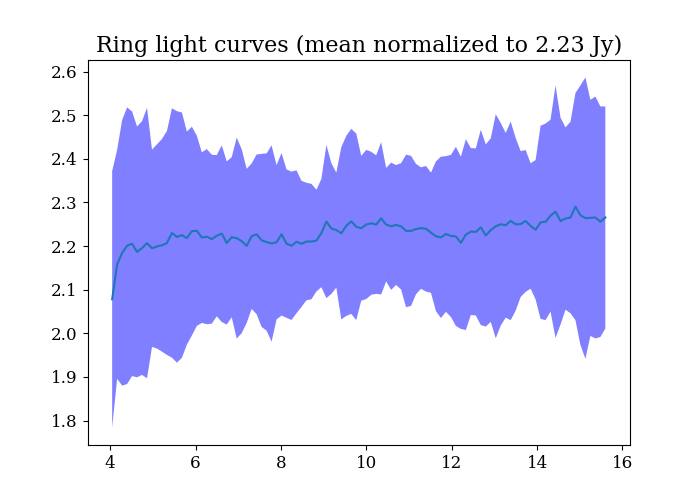

<IPython.core.display.Javascript object>


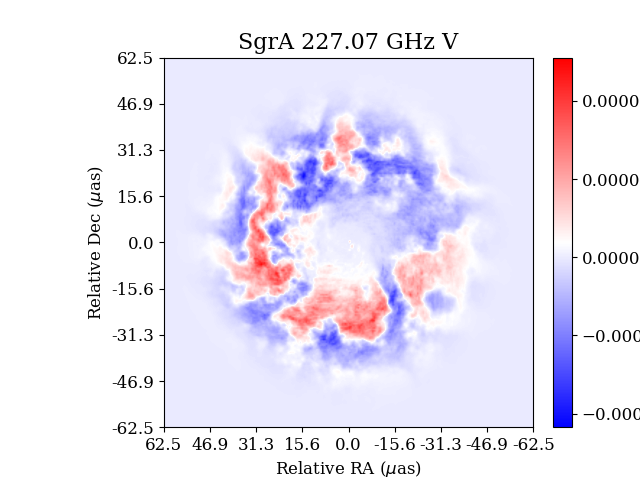

<IPython.core.display.Javascript object>


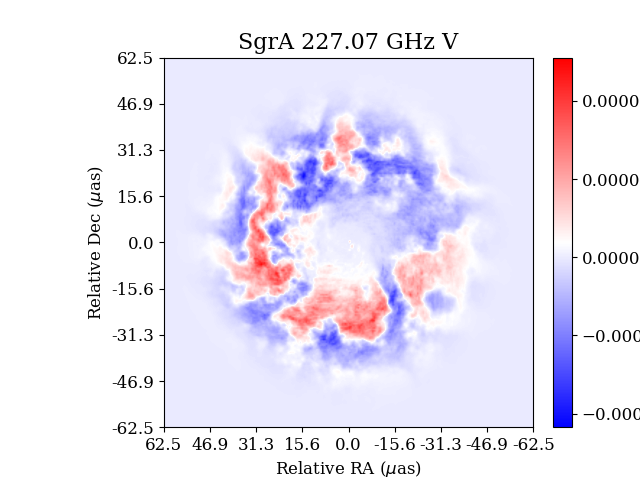

In [429]:
im1 = im.add_random_pol(0.5, 10 * eh.RADPERUAS, 0.1, 5.0* eh.RADPERUAS)
im1.display(pol='V')

In [26]:
# Load a precomputed movie
movie_path = os.path.join(ehtim_home, 'SgrA/synthetic_rings_asc1.0_innerdec5.0/angle1.0_clockwise_eps0.10_len0.1_amp0.30.hdf5')
movie = eh.movie.load_hdf5(movie_path)
movie = add_pol_movie(movie)

eps = so.MakeEpsilonScreen(movie.xdim, movie.ydim, rngseed=34)
scattering_model = so.ScatteringModel()
movie = scattering_model.Scatter_Movie(movie, eps)

savefolder = movie_path[:-5]

add_th_noise = True           # False if you *don't* want to add thermal error. If there are no sefds in obs_orig it will use the sigma for each data point
phasecal = False              # True if you don't want to add atmospheric phase error. if False then it adds random phases to simulate atmosphere
ampcal = False                # True if you don't want to add atmospheric amplitude error. if False then add random gain errors
stabilize_scan_phase = True   # if true then add a single phase error for each scan to act similar to adhoc phasing
stabilize_scan_amp = True     # if true then add a single gain error at each scan
jones = True                  # apply jones matrix for including noise in the measurements (including leakage)
inv_jones = False             # no not invert the jones matrix
frcal = True                  # True if you do not include effects of field rotation
dcal = False                  # True if you do not include the effects of leakage
dterm_offset = 0.05           # a random offset of the D terms is given at each site with this standard deviation away from 1
rlgaincal = True
neggains = True

# these gains are approximated from the EHT 2017 data 
# the standard deviation of the absolute gain of each telescope from a gain of 1
gain_offset = {'AA':0.15, 'AP':0.15, 'AZ':0.15, 'LM':0.6, 'PV':0.15, 'SM':0.15, 'JC':0.15, 'SP':0.15, 'SR':0.0} 
# the standard deviation of gain differences over the observation at each telescope
gainp = {'AA':0.05, 'AP':0.05, 'AZ':0.05, 'LM':0.5, 'PV':0.05, 'SM':0.05, 'JC':0.05, 'SP':0.15, 'SR':0.0} 

obs_noisy = movie.observe_same(obs_sgra, add_th_noise=add_th_noise, ampcal=ampcal, phasecal=phasecal,
        stabilize_scan_phase=stabilize_scan_phase, stabilize_scan_amp=stabilize_scan_amp, gain_offset=gain_offset,
        gainp=gainp, jones=jones,inv_jones=inv_jones,dcal=dcal, frcal=frcal, rlgaincal=rlgaincal, neggains=neggains,
        dterm_offset=dterm_offset, caltable_path= savefolder, sigmat=0.25)
caltable = eh.caltable.load_caltable(obs_noisy, datadir=savefolder +'_simdata_caltable/')
caltable.plot_gains([])

Producing clean visibilities from movie with direct FT . . . 
Applying Jones Matrices to data . . . 
Applying Jones Matrices to data . . . 


Warning!: in add_jones_and_noise, some SEFDs are <= 0!
Resorting to data point sigmas, which may add too much systematic noise!
   Applying gain corruption: ampcal-->False
   Applying atmospheric phase corruption: phasecal-->False
   Applying D Term mixing: dcal-->False
Adding thermal noise to data . . . 


/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/ehtim-1.1.1-py3.7.egg/ehtim/caltable.py:268: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show(block=False)


<IPython.core.display.Javascript object>


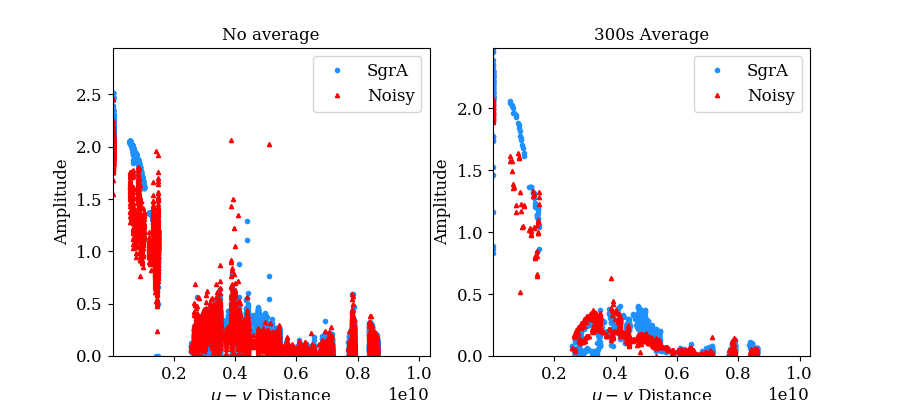

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


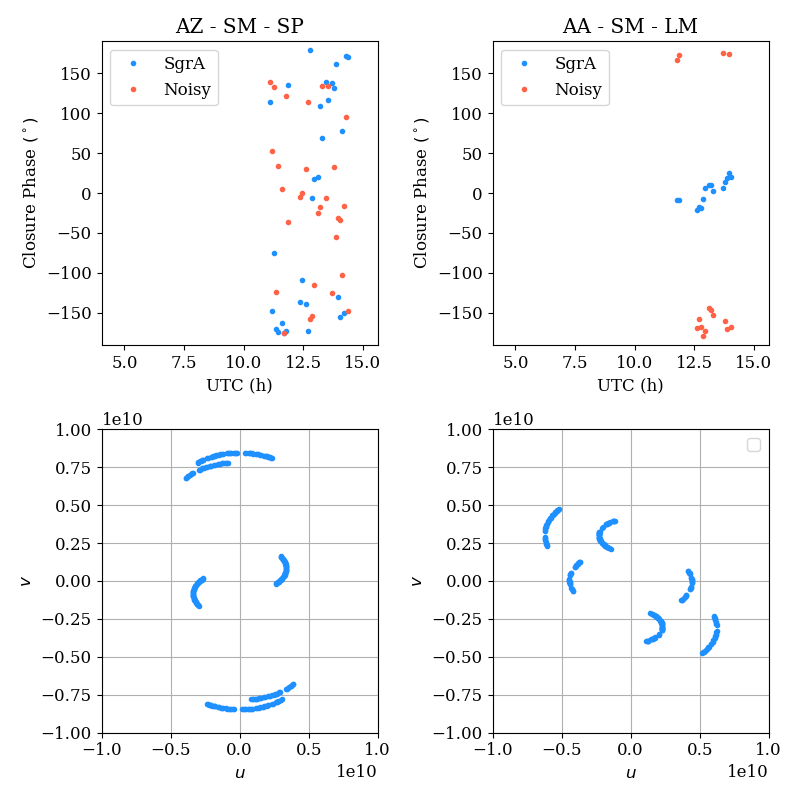

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Flagged 835/960 visibilities
Flagged 851/960 visibilities


In [6]:
inttime = 300
obs_sgr_avg = obs_sgra.avg_coherent(inttime)
obs_noisy_avg = obs_noisy.avg_coherent(inttime)

%matplotlib notebook
plot_amplitudes(obs_sgra, obs_sgr_avg, obs_noisy, obs_noisy_avg, inttime)
plot_closure_phases(obs_sgr_avg, obs_noisy_avg)

In [9]:
di.export_movie(movie.im_list(), fps=10, out='scattering.mp4')
os.system('ffmpeg -i scattering.mp4 scattering.gif')

0

In [32]:
frames = [img.ivec for img in movie.im_list()]
img_list = []
empty = eh.image.make_empty(movie.xdim, movie.fovx(), movie.ra, movie.dec, rf=movie.rf, source=movie.source)
for frame, time  in zip(frames, movie.times):
    img = empty.copy()
    img.time = time
    img.mjd = movie.mjd
    img.ivec = frame
    img_list.append(img)
movie_q = eh.movie.merge_im_list(img_list)
di.export_movie(movie_q.im_list(), fps=10, out='I.mp4')
os.system('ffmpeg -i I.mp4 I.gif')


Merging 100 frames from MJD 57850 4.05 hr to MJD 57850 15.60 hr


0

## Dynamic Disk

<IPython.core.display.Javascript object>


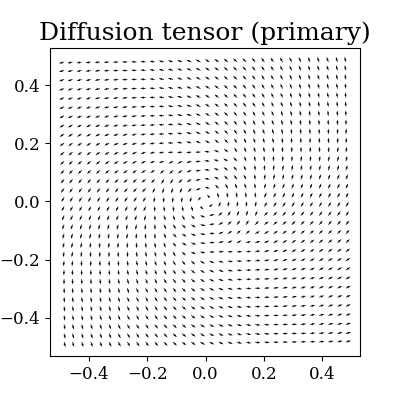

In [10]:
"""
Plot the diffusion tensor of the disk model
"""
diffusion = pynoisy.DiskDiffusion()
radius = 0.75 * 39.346734 / 160.0
diffusion[diffusion.r >= radius] = pynoisy.RingDiffusion(opening_angle=np.pi/3)
plt.figure(figsize=(4,4))
diffusion.plot_principal_axis()

Producing clean visibilities from movie with direct FT . . . 
Applying Jones Matrices to data . . . 
Applying Jones Matrices to data . . . 


Warning!: in add_jones_and_noise, some SEFDs are <= 0!
Resorting to data point sigmas, which may add too much systematic noise!
   Applying gain corruption: ampcal-->False
   Applying atmospheric phase corruption: phasecal-->False
   Applying D Term mixing: dcal-->False
Adding thermal noise to data . . . 


<IPython.core.display.Javascript object>


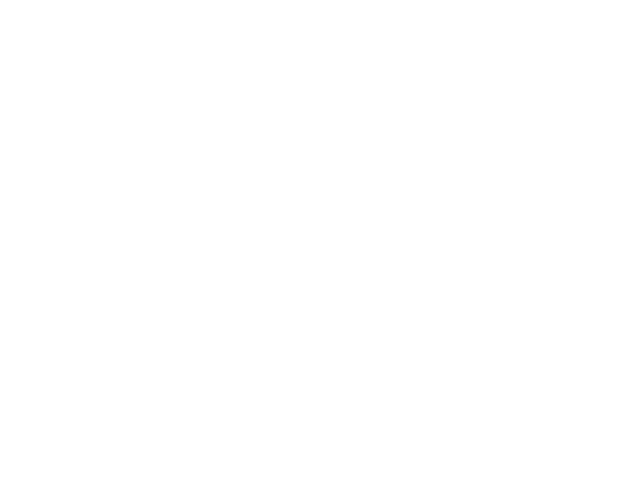

In [11]:
movie_path = os.path.join(ehtim_home, 'SgrA/synthetic_disks/angle0.8_clockwise_eps0.05_len0.1_amp0.15_rat0.1_dec15.hdf5')
movie = eh.movie.load_hdf5(movie_path)
savefolder = movie_path[:-5]

add_th_noise = True           # False if you *don't* want to add thermal error. If there are no sefds in obs_orig it will use the sigma for each data point
phasecal = False              # True if you don't want to add atmospheric phase error. if False then it adds random phases to simulate atmosphere
ampcal = False                # True if you don't want to add atmospheric amplitude error. if False then add random gain errors
stabilize_scan_phase = True   # if true then add a single phase error for each scan to act similar to adhoc phasing
stabilize_scan_amp = True     # if true then add a single gain error at each scan
jones = True                  # apply jones matrix for including noise in the measurements (including leakage)
inv_jones = False             # no not invert the jones matrix
frcal = True                  # True if you do not include effects of field rotation
dcal = False                  # True if you do not include the effects of leakage
dterm_offset = 0.05           # a random offset of the D terms is given at each site with this standard deviation away from 1
seed = 1
rlgaincal = True
neggains = True

# these gains are approximated from the EHT 2017 data 
# the standard deviation of the absolute gain of each telescope from a gain of 1
gain_offset = {'AA':0.15, 'AP':0.15, 'AZ':0.15, 'LM':0.6, 'PV':0.15, 'SM':0.15, 'JC':0.15, 'SP':0.15, 'SR':0.0} 
# the standard deviation of gain differences over the observation at each telescope
gainp = {'AA':0.05, 'AP':0.05, 'AZ':0.05, 'LM':0.5, 'PV':0.05, 'SM':0.05, 'JC':0.05, 'SP':0.15, 'SR':0.0} 

obs_noisy = movie.observe_same(obs_sgra, add_th_noise=add_th_noise, ampcal=ampcal, phasecal=phasecal,
        stabilize_scan_phase=stabilize_scan_phase, stabilize_scan_amp=stabilize_scan_amp, gain_offset=gain_offset,
        gainp=gainp, jones=jones,inv_jones=inv_jones,dcal=dcal, frcal=frcal, rlgaincal=rlgaincal, neggains=neggains,
        dterm_offset=dterm_offset, caltable_path= savefolder + '/dataset_seed_' + str(seed), seed=seed)
caltable = eh.caltable.load_caltable(obs_noisy, datadir=savefolder +'/dataset_seed_1_simdata_caltable/')
caltable.plot_gains([])

<IPython.core.display.Javascript object>


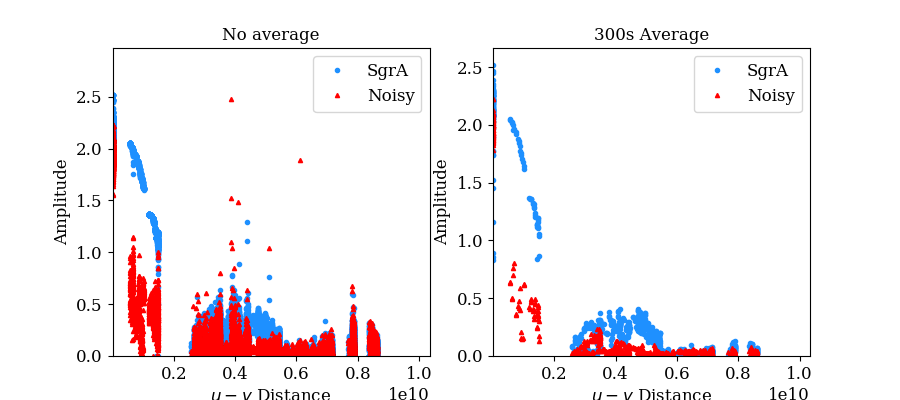

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


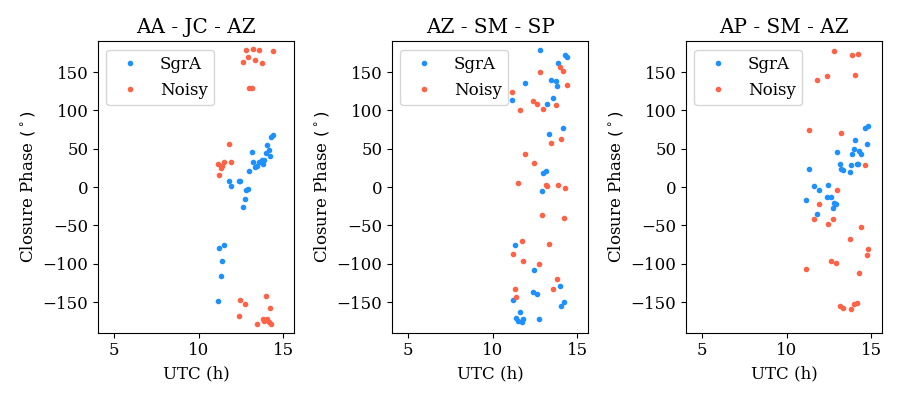

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


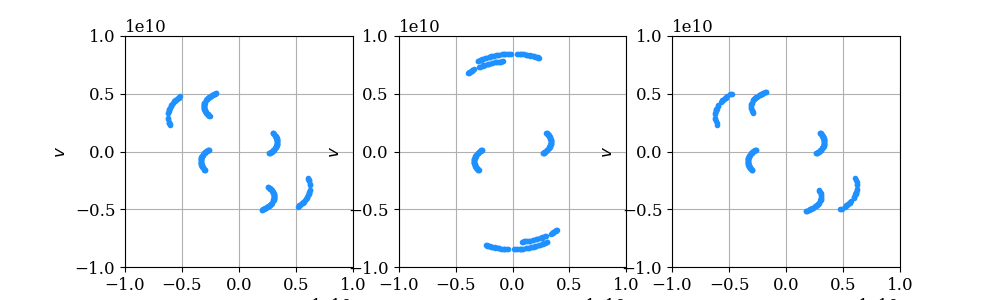

Flagged 839/960 visibilities
Flagged 835/960 visibilities
Flagged 855/960 visibilities


In [12]:
inttime = 300
obs_sgr_avg = obs_sgra.avg_coherent(inttime)
obs_noisy_avg = obs_noisy.avg_coherent(inttime)

%matplotlib notebook
plot_amplitudes(obs_sgra, obs_sgr_avg, obs_noisy, obs_noisy_avg, inttime)
plot_closure_phases(obs_sgr_avg, obs_noisy_avg)


Merging 100 frames from MJD 57850 4.05 hr to MJD 57850 15.60 hr
Producing clean visibilities from movie with nfft FT . . . 
Scattering Visibilities with Sgr A* kernel!


<IPython.core.display.Javascript object>


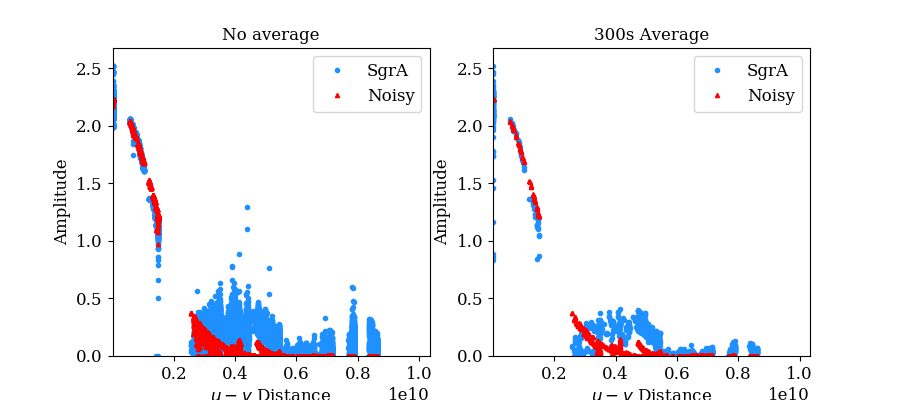

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


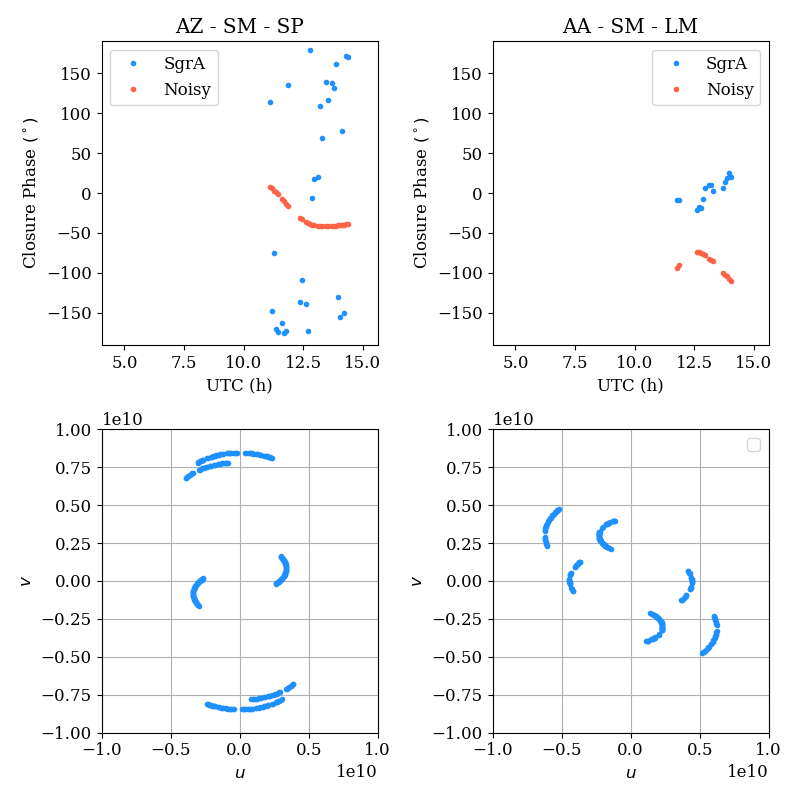

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Flagged 835/960 visibilities
Flagged 851/960 visibilities


In [56]:
"""
Generate a Movie object compare SgrA-like observations amplitudes
"""
movie = ehtim_movie(noisy_movie.frames, obs_sgra, total_flux=2.23, fov=160)
obs_noisy = movie.observe_same_nonoise(obs_sgra, sgrscat=True)

inttime = 300
obs_sgr_avg = obs_sgra.avg_coherent(inttime)
obs_noisy_avg = obs_noisy.avg_coherent(inttime)
    
%matplotlib notebook
plot_amplitudes(obs_sgra, obs_sgr_avg, obs_noisy, obs_noisy_avg, inttime)
plot_closure_phases(obs_sgr_avg, obs_noisy_avg)

## Dynamic Double Source

In [72]:
import pynoisy
import numpy as np
import os
from tqdm import tqdm
from joblib import Parallel, delayed
import ehtim.imaging.dynamical_imaging as di
import pynoisy.eht_functions as ehtf
import itertools

ehtim_home = '/home/aviad/Code/eht-imaging/'
sgr_uvfits_path = 'SgrA/data/calibrated_data_oct2019/frankenstein_3599_lo_SGRA_polcal_netcal_LMTcal_10s.uvfits'

# Hyper-parameters for ring structure
obs_sgra = ehtf.load_sgra_obs(ehtim_home, sgr_uvfits_path)
total_flux = 2.23
fov = 160

# Parameters for different ring evolutions
opening_angles = [np.pi / 3, np.pi / 4]
rotation_directions1 = [pynoisy.RotationDirection.clockwise, pynoisy.RotationDirection.counter_clockwise]
rotation_directions2 = [pynoisy.RotationDirection.clockwise, pynoisy.RotationDirection.counter_clockwise]
forcing_strengths = [0.01, 0.05, 0.1]
evolution_lengths = [0.1, 0.5]
envelope_amplitudes = [0.05, 0.1, 0.2]
source_ratios = [{'flux': 1.0, 'size': 1.0},
                 {'flux': 0.6, 'size': 1.32}]
parameters = itertools.product(opening_angles, rotation_directions1, rotation_directions2, forcing_strengths, evolution_lengths, envelope_amplitudes, source_ratios)

Loading uvfits:  /home/aviad/Code/eht-imaging/SgrA/data/calibrated_data_oct2019/frankenstein_3599_lo_SGRA_polcal_netcal_LMTcal_10s.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!


In [ ]:
# Load a precomputed movie
movie_path = os.path.join(ehtim_home, 'SgrA/synthetic_dbsrc_asymetric/')
movie = eh.movie.load_hdf5(movie_path)
savefolder = movie_path[:-5]

add_th_noise = True           # False if you *don't* want to add thermal error. If there are no sefds in obs_orig it will use the sigma for each data point
phasecal = False              # True if you don't want to add atmospheric phase error. if False then it adds random phases to simulate atmosphere
ampcal = False                # True if you don't want to add atmospheric amplitude error. if False then add random gain errors
stabilize_scan_phase = True   # if true then add a single phase error for each scan to act similar to adhoc phasing
stabilize_scan_amp = True     # if true then add a single gain error at each scan
jones = True                  # apply jones matrix for including noise in the measurements (including leakage)
inv_jones = False             # no not invert the jones matrix
frcal = True                  # True if you do not include effects of field rotation
dcal = False                  # True if you do not include the effects of leakage
dterm_offset = 0.05           # a random offset of the D terms is given at each site with this standard deviation away from 1
seed = 1
rlgaincal = True
neggains = True

# these gains are approximated from the EHT 2017 data 
# the standard deviation of the absolute gain of each telescope from a gain of 1
gain_offset = {'AA':0.15, 'AP':0.15, 'AZ':0.15, 'LM':0.6, 'PV':0.15, 'SM':0.15, 'JC':0.15, 'SP':0.15, 'SR':0.0} 
# the standard deviation of gain differences over the observation at each telescope
gainp = {'AA':0.05, 'AP':0.05, 'AZ':0.05, 'LM':0.5, 'PV':0.05, 'SM':0.05, 'JC':0.05, 'SP':0.15, 'SR':0.0} 

obs_noisy = movie.observe_same(obs_sgra, add_th_noise=add_th_noise, ampcal=ampcal, phasecal=phasecal,
        stabilize_scan_phase=stabilize_scan_phase, stabilize_scan_amp=stabilize_scan_amp, gain_offset=gain_offset,
        gainp=gainp, jones=jones,inv_jones=inv_jones,dcal=dcal, frcal=frcal, rlgaincal=rlgaincal, neggains=neggains,
        dterm_offset=dterm_offset, caltable_path= savefolder + '/dataset_seed_' + str(seed), seed=seed)
caltable = eh.caltable.load_caltable(obs_noisy, datadir=savefolder +'/dataset_seed_1_simdata_caltable/')
caltable.plot_gains([])